In [1]:
#隐藏警告
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Generate an LFR Network and Draw it
import numpy as np
import networkx as nx
from networkx.generators.community import LFR_benchmark_graph


n = 1000
tau1 = 2  # Power-law exponent for the degree distribution
tau2 = 1.1  # Power-law exponent for the community size distribution
# mu = 0.05  # Mixing parameter
avg_deg = 25  # Average Degree
max_deg = int(0.1 * n)  # Max Degree
min_commu = 60  # Min Community Size
max_commu = int(0.1 * n)  # Max Community Size

#for mu in np.arange(0.1, 0.11, 0.1):

In [3]:
from Network import *
import numpy as np
    
import networkx as nx
import scipy.sparse

def to_networkx(self):
    if isinstance(self.graph, scipy.sparse.csr.csr_matrix):
        return nx.from_scipy_sparse_matrix(self.graph)
    else:
        return nx.from_numpy_array(self.graph)

In [4]:
# This function takes the orthogonal part of G_sparse eigenvectors.
# Hopefully, we will get a better community detection result from this treatment.
import networkx as nx
import numpy as np

def compute_orthogonal_components(G, V):
    """
    Compute the component of each column of V orthogonal to the degree sequence vector of a graph.

    Parameters:
    G (networkx.classes.graph.Graph): The input graph.
    V (numpy.ndarray): The input 2D array.

    Returns:
    numpy.ndarray: The component of each column of V orthogonal to the degree sequence vector of the graph.
    """
    # get measure and constant vector
    mu = np.array([d for n, d in G.degree()])
    u = np.ones(G.number_of_nodes())

    # 
    orthogonal_components = np.zeros_like(V)

    # do orthogonal for each column
    for i in range(V.shape[1]):
        v = V[:, i]
        orthogonal_component = v - ((v @ (u * mu)) / (u @ (u * mu))) * u
        orthogonal_components[:, i] = orthogonal_component  # 

    return orthogonal_components

In [5]:
# This is the function for Laplacian Eigenmap using Cupy. The presence of GPU is required.

import numpy as np
import networkx as nx
import cupy as cp

def lap_cupy(graph, dim):
    """
    Compute the Laplacian embedding of a graph using CuPy.

    Parameters:
    graph (networkx.classes.graph.Graph): The input graph.
    dim (int): The dimension of the embedding.

    Returns:
    numpy.ndarray: The Laplacian embedding of the graph.
    """
    # Check inputs
    assert isinstance(graph, nx.Graph), "Input graph must be a NetworkX graph."
    assert isinstance(dim, int) and dim > 0, "Input dim must be a positive integer."
    assert dim < graph.number_of_nodes(), "Input dim must be less than the number of nodes in the graph."

    # Convert the adjacency matrix of the graph to a CuPy array
    A = cp.asarray(nx.adjacency_matrix(graph, nodelist=graph.nodes(), weight='weight').toarray(), dtype=cp.float64)

    # Compute L1 normalization along axis 1 (rows)
    row_sums = cp.linalg.norm(A, ord=1, axis=1)
    A /= row_sums.reshape(-1, 1)

    # Compute the eigenvalues and eigenvectors of I_n - A
    I_n = cp.eye(graph.number_of_nodes())
    w, v = cp.linalg.eigh(I_n - A)

    # Sort the eigenvectors by the real part of the eigenvalues
    v = v[:, cp.argsort(w.real)]

    # Return the embedding
    return v[:, 1:(dim+1)].get().real  # Explicitly convert to NumPy array using .get()

In [6]:
### KMeans Clustering using Euclidean and Spherical metrics
### Using NMI and ECSim for comparison
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_distances
from sklearn.preprocessing import normalize
from sklearn.metrics import normalized_mutual_info_score
import clusim.sim as sim
from clusim.clustering import Clustering


def euclid_membership(K, points):
    euc_kmeans = KMeans(n_clusters=K, n_init=10)
    euc_kmeans.fit(points)

    evala_euclid_membership = euc_kmeans.labels_
    return evala_euclid_membership

def cosine_membership(K, points):
    normalized_points = normalize(points)
    cos_kmeans = KMeans(n_clusters=K, n_init=10)
    cos_kmeans.fit(normalized_points)

    evala_cosine_membership = cos_kmeans.labels_
    return evala_cosine_membership

def calculate_score(evala, intr_list, K):
# evala is the embedding vectors
# intr_list is the intrinsic community strucuture
# K is the number of clusters in Kmeans
    return_val = [] # 首先准备好返回值 

    intr_clus = Clustering({i: [intr_list[i]] for i in range(len(intr_list))})

    evala_euclid_membership = euclid_membership(K, evala)

    evala_cosine_membership = cosine_membership(K, evala)

    ## compare with intrinsic community structure using NMI
    return_val.append(normalized_mutual_info_score(evala_euclid_membership, intr_list, average_method='arithmetic'))
    return_val.append(normalized_mutual_info_score(evala_cosine_membership, intr_list, average_method='arithmetic'))
    
    
    evala_euclid_clustering = Clustering(elm2clu_dict={i: [evala_euclid_membership[i]] for i in range(len(evala_euclid_membership))})
    evala_cosine_clustering = Clustering(elm2clu_dict={i: [evala_cosine_membership[i]] for i in range(len(evala_cosine_membership))})
    
    ## compare with intrinsic community structure using ECSim
    evala_euclid_similarity = sim.element_sim(intr_clus, evala_euclid_clustering, alpha=0.9)
    evala_cosine_similarity = sim.element_sim(intr_clus, evala_cosine_clustering, alpha=0.9)
    return_val.append(evala_euclid_similarity)
    return_val.append(evala_cosine_similarity)
    
    return return_val

In [7]:
import numpy as np

step_total  = 10
step_size = 0.05
MU = [0.25]

SAMPLE = 5

stat = np.zeros((step_total, 3, 4))

K = 15

RAW_SCORE={}

In [8]:
for mu in MU:
    RAW_SCORE[mu] = np.zeros((SAMPLE, 3, 4))
    for i in range(SAMPLE):
        G = LFR_benchmark_graph(
        n, tau1, tau2, mu, average_degree=avg_deg, max_degree=max_deg, min_community=min_commu, max_community=max_commu,
        seed=2024
        )

        # Remove multi-edges and self-loops from G
        G = nx.Graph(G)
        selfloop_edges = list(nx.selfloop_edges(G))
        G.remove_edges_from(selfloop_edges)

        # LFR 图是有内在的社群结构的，每个节点的社群存储在其 community 属性中，是一个 set
        # 通过运行循环，按照内在的社群结构给每个节点一个标签 即为其 intrinsic_membership
        # 为了方便 intrinsic_membership 一开始是作为一个 dict 存储的，后来将其转化为一个 list
        intrinsic_communities = {frozenset(G.nodes[v]["community"]) for v in G}
        intrinsic_membership = {}
        for node in range(G.number_of_nodes()):
            for index, inner_set in enumerate(intrinsic_communities):
                if node in inner_set:
                    intrinsic_membership[node] = index
                    break
        intrinsic_membership = list(intrinsic_membership.values())

        # Get the edge list and edge weights and transform G from NetworkX to Network

        # Get edge list as a numpy array
        edge_list = list(G.edges())
        edge_list = np.array(edge_list)

        # Get edge weights as a numpy array
        edge_weights = nx.get_edge_attributes(G, 'weight')
        edge_weights = np.array(edge_weights)

        edge_weights = [edge_weights[edge] if edge in edge_weights else 1 for edge in edge_list]

        Gn = Network(edge_list, edge_weights)
        # Gn is the representation of G in Network format

        # Calculate effective resistance
        epsilon=0.1
        method='spl'
        Effective_R = Gn.effR(epsilon, method)

        # spectral sparse version of G in Network format
        q = 10000
        seed = 2024
        Gn_Sparse = Gn.spl(q, Effective_R, seed=seed)

        # G_sparse is the spectral sparse version of G in NetworkX format    
        G_sparse = to_networkx(Gn_Sparse)
        # check whether the sparse version is connected or not
        print(nx.is_connected(G_sparse))

        score_sparse_orth = calculate_score(
            compute_orthogonal_components(G, lap_cupy(G_sparse,K)),intrinsic_membership, len(np.unique(intrinsic_membership)))
        RAW_SCORE[mu][i,0] = score_sparse_orth
        score_sparse = calculate_score(lap_cupy(G_sparse,K),intrinsic_membership, len(np.unique(intrinsic_membership)))
        RAW_SCORE[mu][i,1] = score_sparse
        score_original = calculate_score(lap_cupy(G,K),intrinsic_membership, len(np.unique(intrinsic_membership)))
        RAW_SCORE[mu][i,2] = score_original
    stat[0] = np.mean(RAW_SCORE[mu],axis=0)

True
True
True
True
True


In [9]:
RAW_SCORE

{0.25: array([[[0.89529363, 0.90421978, 0.88437852, 0.89347638],
         [0.8982597 , 0.90000385, 0.88796445, 0.88967941],
         [0.99794658, 0.99796984, 0.99704227, 0.99704461]],
 
        [[0.81083838, 0.91794622, 0.7036674 , 0.90825617],
         [0.79576949, 0.91586958, 0.66997488, 0.90559465],
         [0.99794658, 0.99796984, 0.99704227, 0.99704461]],
 
        [[0.89684455, 0.91731778, 0.87412324, 0.90357864],
         [0.8684638 , 0.91175063, 0.81040885, 0.89639796],
         [0.99794658, 0.99796984, 0.99704227, 0.99704461]],
 
        [[0.91075078, 0.89707418, 0.89252778, 0.8802806 ],
         [0.8150286 , 0.89867677, 0.71866604, 0.88297357],
         [0.99794658, 0.99796984, 0.99704227, 0.99704461]],
 
        [[0.83618804, 0.91122068, 0.75502202, 0.89787222],
         [0.83824391, 0.91600187, 0.7704963 , 0.90257321],
         [0.99794658, 0.99796984, 0.99704227, 0.99704461]]])}

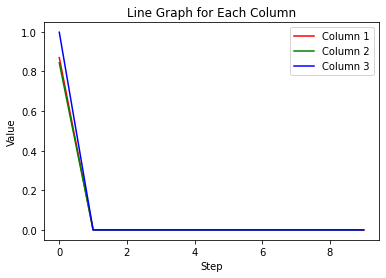

In [10]:
import numpy as np
import matplotlib.pyplot as plt

x=0

# 绘制每列的折线图
plt.plot(stat[:, 0, x], label='Column 1', color='r')  # 红色曲线
plt.plot(stat[:, 1, x], label='Column 2', color='g')  # 绿色曲线
plt.plot(stat[:, 2, x], label='Column 3', color='b')  # 蓝色曲线

# 添加图例
plt.legend()

# 添加标签
plt.xlabel('Step')
plt.ylabel('Value')
plt.title('Line Graph for Each Column')

# 显示图形
plt.show()

In [11]:
stat

array([[[0.86998307, 0.90955573, 0.82194379, 0.8966928 ],
        [0.8431531 , 0.90846054, 0.7715021 , 0.89544376],
        [0.99794658, 0.99796984, 0.99704227, 0.99704461]],

       [[0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
    